# 5.  Modeling 
##  (1) <span style = 'color:darkcyan'>Arima 모델</span>을 사용하여 6,7,8월 음식물 쓰레기 예측

- 본 분석에서는 각 연도-월별 음식물 쓰레기 배출량에 대한 코싸인 유사도를 계산하여 2021-07, 2021-08과 유사할 것으로 예상되는 데이터들의 평균을 이용하여 예측을 수행한다. 먼저, 2021년 6월과 코싸인 유사도가 높은 상위 n개의 데이터의 평균을 사용하여 2021-06에 대한 예측을 수행한다. 이를 기반으로 2021년 7월과 8월과의 유사한 데이터를 찾아 예측을 수행한다.

In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas import datetime
import datetime
import matplotlib.pylab as plt
%matplotlib inline             
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import statsmodels as sm
from matplotlib.collections import PolyCollection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False) 
from numpy import dot
from numpy.linalg import norm
from pmdarima.arima import auto_arima

<ipython-input-1-33d48633b037>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
cluster_0 = pd.read_csv('features/군집0_feature_corona.csv')
cluster_1 = pd.read_csv('features/군집1_feature_corona.csv')
cluster_2 = pd.read_csv('features/군집2_feature_corona.csv')
cluster_3 = pd.read_csv('features/군집3_feature_corona.csv')
cluster_4 = pd.read_csv('features/군집4_feature_corona.csv')
cluster_5 = pd.read_csv('features/군집5_feature_corona.csv')
# cluster_6 = pd.read_csv('군집6_feature_corona.csv')

- 본 분석에서는 각 연도-월별 음식물 쓰레기 배출량에 대한 코싸인 유사도를 계산하여 2021-07, 2021-08과 유사할 것으로 예상되는 데이터들의 평균을 이용하여 예측을 수행한다. 먼저, 2021년 6월과 코싸인 유사도가 높은 상위 n개의 데이터의 평균을 사용하여 2021-06에 대한 예측을 수행한다. 이를 기반으로 2021년 7월과 8월과의 유사한 데이터를 찾아 예측을 수행한다.

- 코싸인 유사도 계산을 위한 함수는 다음과 같다.

In [3]:
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

# 2021-06 예측

In [4]:
re = []   # 예측값 저장을 위한 리스트

# Cluster0

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [5]:
cluster0 = cluster_0.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster0['year_month'] = cluster0['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster0 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos

# 코싸인 유사도가 높은 상위 3개의 year_month를 lst 이름의 리스트에 저장
lst = []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-3:-1] :
        j = int(j)
        lst.append(coss.iloc[:,j].name[2])

        
cluster0 = cluster0.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster0.query('base_date_jh >= "2021-06-01"').iloc[:,:3]  # 2021-6월의 실제 배출량을 answer로 저장
cluster0 = cluster0.query('base_date_jh < "2021-06-01"') # cluster0에서 2021-6을 제외 

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster0['dong']=encoder.fit_transform(cluster0['emd_nm_jh'])

cluster0 = cluster0.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster0['base_date_jh']=pd.to_datetime(cluster0['base_date_jh'])
cluster0['day'] = cluster0['base_date_jh'].dt.day
cluster0['month'] = cluster0['base_date_jh'].dt.month
cluster0['year'] = cluster0['base_date_jh'].dt.year
cluster0['week'] = cluster0['base_date_jh'].dt.weekofyear

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster0.query('year_month not in @lst ') 

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster0.query('year_month in @lst')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:-3].to_list()
col2=X_test.columns[-3:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [6]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -7.878
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [7]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=426471.236, Time=4.45 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=426463.332, Time=13.49 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=426422.190, Time=20.18 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=426194.111, Time=28.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=426464.246, Time=7.15 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=426463.137, Time=45.60 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=426297.072, Time=48.43 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=426160.918, Time=57.70 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=426424.607, Time=19.98 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=426243.675, Time=72.48 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=423310.145, Time=427.93 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=423137.338, Time=257.89 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=426100.460, Time=16.08 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=425990.352, Time=49.03 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept 

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [8]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(3,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [9]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  155293.8281957187
동별  3253119.473099571


Text(0.5, 1.0, 'Cluster0 ARIMA Modeling')

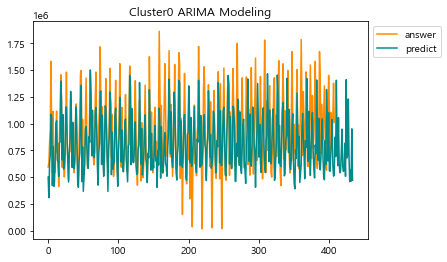

In [10]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster0.query('year_month in @lst').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster0 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

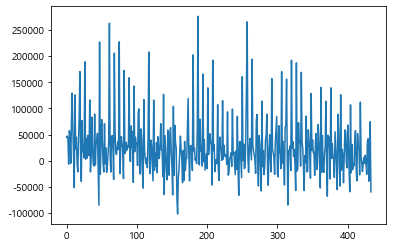

In [11]:
resi = np.array(y_test) - np.array(forecast)
plt.plot(resi) 

#### 예측 값 저장
- cluster0에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [12]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima0') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima0']) 

# cluster1

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [13]:
cluster1 = cluster_1.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster1['year_month'] = cluster1['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster1 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성 
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos

# 코싸인 유사도가 높은 상위 20개의 year_month를 lst1 이름의 리스트에 저장    
lst1 = []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-20:-1] :
        j = int(j)
        lst1.append(coss.iloc[:,j].name[2])

cluster1 = cluster1.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster1.query('base_date_jh >= "2021-06-01"').iloc[:,:3] # 2021-6월의 실제 배출량을 answer로 저장
cluster1 = cluster1.query('base_date_jh < "2021-06-01"') # cluster0에서 2021-6을 제외 

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster1['dong']=encoder.fit_transform(cluster1['emd_nm_jh'])

cluster1 = cluster1.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster1['base_date_jh']=pd.to_datetime(cluster1['base_date_jh'])
cluster1['day'] = cluster1['base_date_jh'].dt.day
cluster1['month'] = cluster1['base_date_jh'].dt.month
cluster1['year'] = cluster1['base_date_jh'].dt.year
cluster1['week'] = cluster1['base_date_jh'].dt.weekofyear

# 2021-6월과 코싸인 유사도가 높은 상위 20개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster1.query('year_month not in @lst1 ')  

# 2021-6월과 코싸인 유사도가 높은 상위 20개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster1.query('year_month in @lst1')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:-3].to_list()
col2=X_test.columns[-3:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [14]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -4.362
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [15]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=34508.908, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=34510.877, Time=0.93 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=34230.686, Time=1.73 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=34232.689, Time=1.76 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=34510.843, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=34469.540, Time=4.24 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=34232.677, Time=2.64 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=34234.685, Time=1.95 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=34285.357, Time=1.28 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=34287.360, Time=1.79 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=34234.667, Time=3.38 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=34236.677, Time=2.55 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=34287.358, Time=1.37 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=34289.360, Time=1.58 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=34236.661, Time=4.20

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [16]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [17]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  425247.87382762023
동별  2664326.605170518


Text(0.5, 1.0, 'Cluster1 ARIMA Modeling')

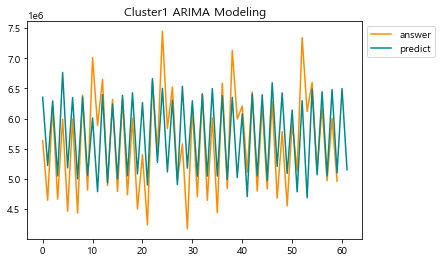

In [18]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster1.query('year_month in @lst1').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster1 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

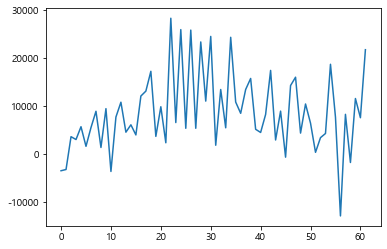

In [19]:
resi = np.array(y_test) - np.array(forecast)

plt.plot(resi) 

#### 예측 값 저장
- cluster1에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [20]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima1') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima1']) 

# cluster2

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [21]:
cluster2 = cluster_2.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster2['year_month'] = cluster2['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster2 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos
    
# 코싸인 유사도가 높은 상위 30개의 year_month를 lst2 이름의 리스트에 저장
lst2 = []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-30:-1] :
        j = int(j)
        lst2.append(coss.iloc[:,j].name[2])

cluster2 = cluster2.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster2.query('base_date_jh >= "2021-06-01"').iloc[:,:3]  # 2021-6월의 실제 배출량을 answer로 저장

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster2['dong']=encoder.fit_transform(cluster2['emd_nm_jh'])

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster2 = cluster2.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
cluster2['base_date_jh']=pd.to_datetime(cluster2['base_date_jh'])
cluster2['dayofweek'] = cluster2['base_date_jh'].dt.dayofweek
cluster2['day'] = cluster2['base_date_jh'].dt.day
cluster2['month'] = cluster2['base_date_jh'].dt.month
cluster2['year'] = cluster2['base_date_jh'].dt.year

dayofweek = cluster2.query('base_date_jh > "2021-05-31"')[['dong','dayofweek']] # dayofweek를 평균이 아닌 실제 값으로 맞춰주기 위해 dayofweek 저장
cluster2 = cluster2.query('base_date_jh < "2021-06-01"') # cluster2에서 2021-6을 제외 

# 2021-6월과 코싸인 유사도가 높은 상위 30개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster2.query('year_month not in @lst2 ')  

# 2021-6월과 코싸인 유사도가 높은 상위 30개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster2.query('year_month in @lst2')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:-2].to_list()
col2=X_test.columns[-2:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

# X_test의 dayofweek를 실제 값으로 변경해줌
j , k = dayofweek.iloc[-1]
dayofweek['index'] = [ i for i in range(ind,ind+X_test.shape[0] - j -1 )]
dayofweek = dayofweek.set_index('index')
X_test['dayofweek'] = dayofweek['dayofweek']
X_test = X_test.fillna(k+1)

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [22]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -4.420
원 데이터 p-value: 0.000


#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

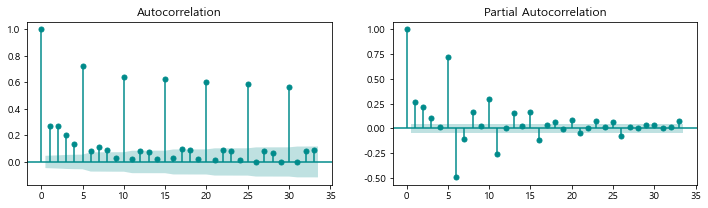

In [23]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

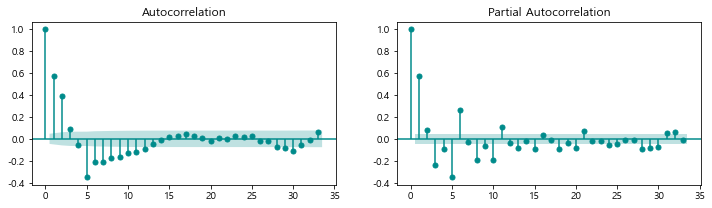

In [24]:
n = cluster2.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [25]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=47187.105, Time=6.65 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=47223.413, Time=4.79 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=47223.408, Time=12.39 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=47220.373, Time=17.21 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=47198.269, Time=5.81 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=47245.510, Time=17.85 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=47229.265, Time=14.52 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=47228.202, Time=15.04 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=47210.543, Time=31.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=47244.046, Time=16.55 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=47229.610, Time=10.48 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=47243.281, Time=23.25 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=47231.980, Time=9.33 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=47234.585, Time=11.06 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=47240.889,

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [26]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,1,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [27]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  355118.64436151384
동별  5925438.646190298


Text(0.5, 1.0, 'Cluster2 ARIMA Modeling')

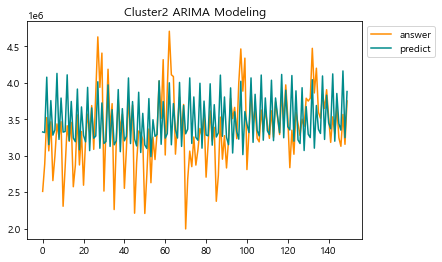

In [28]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster2.query('year_month in @lst2').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast)[:150].reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster2 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

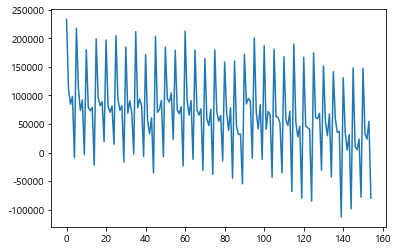

In [29]:
resi = np.array(y_test) - np.array(forecast)
plt.plot(resi) 

#### 예측 값 저장
- cluster2에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [30]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima2') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima2']) 

# cluster3

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [31]:
cluster3 = cluster_3.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster3['year_month'] = cluster3['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster3 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos

# 코싸인 유사도가 높은 상위 10개의 year_month를 lst3 이름의 리스트에 저장
lst3 = []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-10:-1] :
        j = int(j)
        lst3.append(coss.iloc[:,j].name[2])

cluster3 = cluster3.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster3.query('base_date_jh >= "2021-06-01"').iloc[:,:3] # 2021-6월의 실제 배출량을 answer로 저장
cluster3 = cluster3.query('base_date_jh < "2021-06-01"') # cluster0에서 2021-6을 제외 

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster3['dong']=encoder.fit_transform(cluster3['emd_nm_jh'])

cluster3 = cluster3.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster3['base_date_jh']=pd.to_datetime(cluster3['base_date_jh'])
cluster3['day'] = cluster3['base_date_jh'].dt.day
cluster3['month'] = cluster3['base_date_jh'].dt.month
cluster3['year'] = cluster3['base_date_jh'].dt.year
cluster3['week'] = cluster3['base_date_jh'].dt.weekofyear

# 2021-6월과 코싸인 유사도가 높은 상위 10개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster3.query('year_month not in @lst3 ')  

# 2021-6월과 코싸인 유사도가 높은 상위 10개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster3.query('year_month in @lst3')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']
col1=X_test.columns[1:-3].to_list()
col2=X_test.columns[-3:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# X_test의 column 순서를 X_train과 동일하게 변경
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [32]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -7.306
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [33]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=267986.898, Time=9.79 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=267988.758, Time=14.29 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=267986.106, Time=18.90 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=267988.063, Time=29.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=267988.763, Time=11.90 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=267989.849, Time=174.03 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=267988.092, Time=139.09 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=267990.006, Time=46.21 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=267985.928, Time=14.77 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=267988.060, Time=23.99 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=426.10 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=369.78 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=267987.821, Time=21.85 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=267989.823, Time=39.92 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [34]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(2,0,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [35]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  270858.0872241831
동별  4542466.37172901


Text(0.5, 1.0, 'Cluster3 ARIMA Modeling')

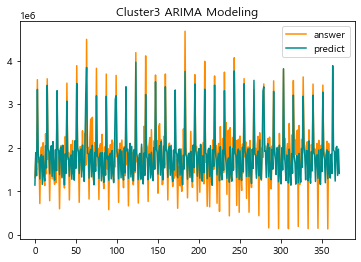

In [36]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster3.query('year_month in @lst3').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster3 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

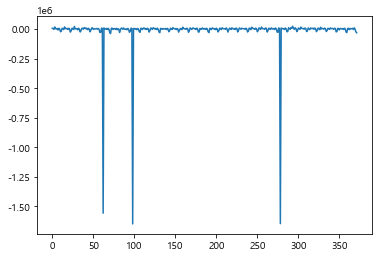

In [37]:
resi = np.array(y_test) - np.array(forecast)
plt.plot(resi) 

#### 예측 값 저장
- cluster3에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [38]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima3') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima3']) 

# Cluster4

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [39]:
cluster4 = cluster_4.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster4['year_month'] = cluster4['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster4 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos

# 코싸인 유사도가 높은 상위 3개의 year_month를 lst4 이름의 리스트에 저장    
lst4 = []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-3:-1] :
        j = int(j)
        lst4.append(coss.iloc[:,j].name[2])

cluster4 = cluster4.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster4.query('base_date_jh >= "2021-06-01"').iloc[:,:3] # 2021-6월의 실제 배출량을 answer로 저장
cluster4 = cluster4.query('base_date_jh < "2021-06-01"')  # cluster0에서 2021-6을 제외 

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster4['dong']=encoder.fit_transform(cluster4['emd_nm_jh'])

cluster4 = cluster4.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster4['base_date_jh']=pd.to_datetime(cluster4['base_date_jh'])
cluster4['day'] = cluster4['base_date_jh'].dt.day
cluster4['month'] = cluster4['base_date_jh'].dt.month
cluster4['year'] = cluster4['base_date_jh'].dt.year
cluster4['week'] = cluster4['base_date_jh'].dt.weekofyear

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster4.query('year_month not in @lst4 ')  

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster4.query('year_month in @lst4')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:-3].to_list()
col2=X_test.columns[-3:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [40]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -0.558
원 데이터 p-value: 0.880


#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

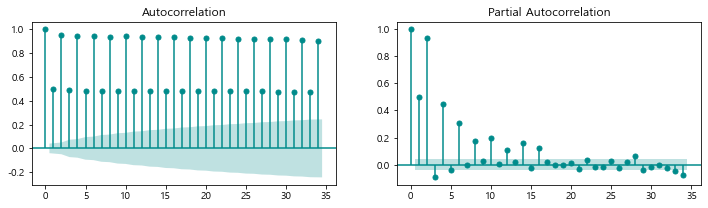

In [41]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

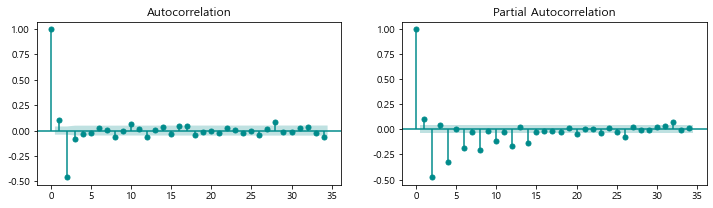

In [42]:
n = cluster4.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [43]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=60348.170, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=60638.157, Time=2.86 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=60768.231, Time=16.71 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=60849.283, Time=25.82 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=60445.333, Time=2.73 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=61241.346, Time=16.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=60818.190, Time=18.59 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=60904.296, Time=16.71 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=60562.381, Time=5.42 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=61097.346, Time=15.79 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=60824.515, Time=27.55 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=60946.875, Time=15.09 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=60645.406, Time=13.25 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=60671.012, Time=15.54 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=60827.119,

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [44]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,1,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [45]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  774237.0116949399
동별  17311861.39063549


Text(0.5, 1.0, 'Cluster4 ARIMA Modeling')

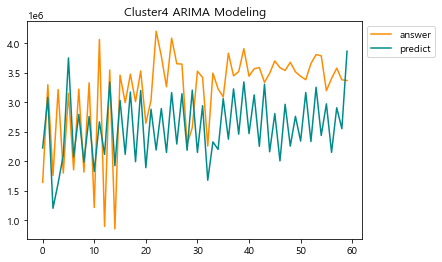

In [46]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster4.query('year_month in @lst4').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster4 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

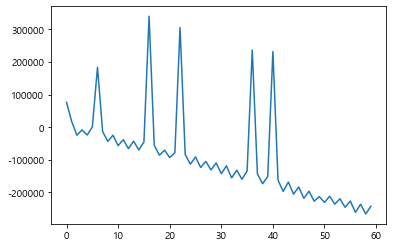

In [47]:
resi = np.array(y_test) - np.array(forecast)

plt.plot(resi) 

#### 예측 값 저장
- cluster4에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [48]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima4') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima4']) 

# Cluster5

#### train, test data set 구축
- 2021-6월의 음식물 쓰레기 배출량과 코싸인 유사도가 높은 상위 n개의 year_month (연도-달)를 찾음 
- 그에 해당하는 데이터를 day(일)와 emd_nm_jh(동)으로 묶고 평균내어 2021-6을 대변하는 data set으로 가정 후, test data로 사용
- 나머지 데이터를 train data로 사용 

In [49]:
cluster5 = cluster_5.copy()

# 년도-월 형태로 생긴 year_month 변수 생성 
cluster5['year_month'] = cluster5['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster5 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 코싸인 유사도를 계산한 결과를 저장할 딕셔너리 생성
dic = {'이름' : 0 }

# 앞에서 만든 pivot table을 사용하여 2021년 6월의 음식물 쓰레기 배출량의 합과 각 year_month 별 코싸인 유사도 계산 후 dic에 저장 
for i in range(42) : 
    cos = cos_sim(coss.iloc[:,-1] , coss.iloc[:,i] )
    name = str(i)
    dic[name] = cos

# 코싸인 유사도가 높은 상위 3개의 year_month를 lst5 이름의 리스트에 저장
lst5= []
for j,k in dic.items() : 
    if k in sorted(dic.values())[-3:-1] :
        j = int(j)
        lst5.append(coss.iloc[:,j].name[2])

cluster5 = cluster5.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )
answer = cluster5.query('base_date_jh >= "2021-06-01"').iloc[:,:3]  # 2021-6월의 실제 배출량을 answer로 저장
cluster5 = cluster5.query('base_date_jh < "2021-06-01"')  # cluster0에서 2021-6을 제외 

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster5['dong']=encoder.fit_transform(cluster5['emd_nm_jh'])

cluster5 = cluster5.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster5['base_date_jh']=pd.to_datetime(cluster5['base_date_jh'])
cluster5['day'] = cluster5['base_date_jh'].dt.day
cluster5['month'] = cluster5['base_date_jh'].dt.month
cluster5['year'] = cluster5['base_date_jh'].dt.year
cluster5['week'] = cluster5['base_date_jh'].dt.weekofyear

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month를 제외한 나머지 데이터를 train set으로 사용
X_train = cluster5.query('year_month not in @lst5 ')

# 2021-6월과 코싸인 유사도가 높은 상위 3개의 year_month에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster5.query('year_month in @lst5')
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 
y_test = X_test['em_g_jh']

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:-3].to_list()
col2=X_test.columns[-3:].to_list()
new_col=col1+['day'] +col2
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 6
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [50]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -3.354
원 데이터 p-value: 0.013


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [51]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=65157.671, Time=1.96 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=65037.186, Time=5.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=64942.498, Time=4.93 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=64944.456, Time=6.88 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=64988.560, Time=9.72 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=64877.157, Time=15.94 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=64855.265, Time=18.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=64834.396, Time=17.50 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=64928.207, Time=4.50 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=64788.516, Time=19.62 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=64775.842, Time=19.97 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=64669.650, Time=28.03 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=64928.997, Time=4.34 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=64787.620, Time=17.22 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=64679.979, Ti

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [52]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(2,0,3),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [53]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인
- 예측 결과와 실제 2021-6월 배출량과의 mae 계산 ( 이때, 날짜 및 동별 mae와 동별 배출량 총합의 mae 모두 출력 )
- 예측 결과를 실제 2021-6월과 비교하는 시각화 진행

일별 , 동별  692574.264820966
동별  17179979.843486786


Text(0.5, 1.0, 'Cluster5 ARIMA Modeling')

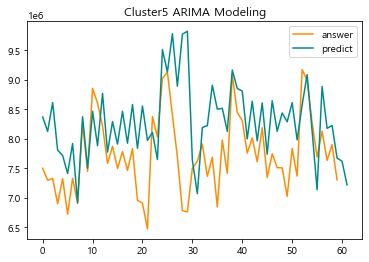

In [54]:
answer['day'] = answer['base_date_jh'].apply(lambda x : int(x[-2:]))
a = cluster5.query('year_month in @lst5').groupby(['day' , 'emd_nm_jh' ]).mean().reset_index().iloc[:,:2]
pred = pd.concat([a ,forecast.reset_index().drop('index' , axis = 1)] , axis = 1 )
can = pd.merge( answer , pred , on = ['day' , 'emd_nm_jh'])
i = can.groupby('emd_nm_jh')['em_g_jh'].sum().reset_index()
j = can.groupby('emd_nm_jh')['predicted_mean'].sum().reset_index()
print( "일별 , 동별 " , mean_absolute_error(can['em_g_jh'] , can['predicted_mean'])  )
print( "동별 " , mean_absolute_error(i['em_g_jh'] , j['predicted_mean'])  )

answer['em_g_jh'].reset_index(drop=True).plot(color='darkorange')
pd.Series(forecast).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['answer','predict'],bbox_to_anchor=(1,1))
plt.title('Cluster5 ARIMA Modeling')

#### 잔차분석
- 잔차분석을 통해 잔차가 특별한 패턴을 가지고 있지는 않은 지 확인

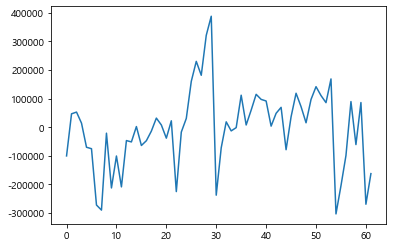

In [55]:
resi = np.array(y_test) - np.array(forecast)

plt.plot(resi) 

#### 예측 값 저장
- cluster5에 대한 6월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [56]:
re.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima5') ] ,axis = 1 ).query('day <31').sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima5']) 

### 군집별 예측 결과 csv 생성

In [57]:
df = re[0].reset_index(drop=True)

for i in range(1,6) :
    a = re[i].reset_index(drop= True)
    df = pd.concat( [df, a] , axis = 1 )

In [58]:
df.to_csv('predict/arima_06_predict.csv' , index = False)

# 2021-07 예측

In [59]:
re_07 = [] # 예측값 저장을 위한 리스트

# cluster0

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

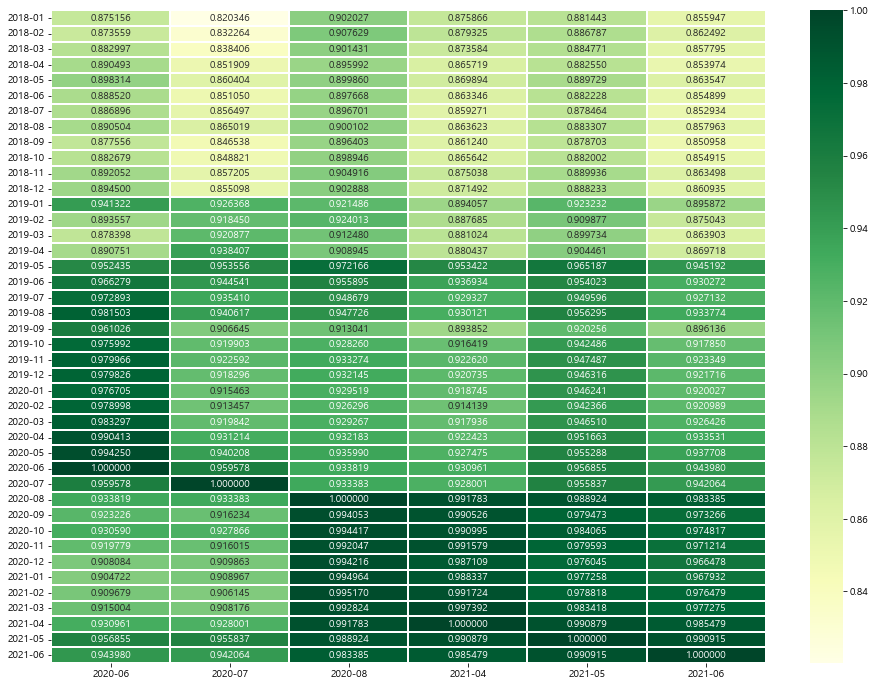

In [60]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_0['year_month'] = cluster_0['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_0 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in ['2020-06','2020-07','2020-08','2021-04', '2021-05','2021-06'] : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_0['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- 2021-06이 1년 전 데이터인 2020-06보다 2021-04, 2021-05와 유사함을 확인할 수 있음
- 또한, 2020-06과 2020-07 모두 2021년 데이터와의 코싸인 유사도가 다소 떨어짐
- 위의 사안들을 감안하여 2021-07과 유사한 year_month를 2021-05 , 2021-06으로 선정

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [61]:
lst_0 = ['2021-05' , '2021-06']

cluster_0 = cluster_0.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_0['dong']=encoder.fit_transform(cluster_0['emd_nm_jh'])

cluster_0 = cluster_0.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_0['base_date_jh']=pd.to_datetime(cluster_0['base_date_jh'])
cluster_0['month'] = cluster_0['base_date_jh'].dt.month
cluster_0['year'] = cluster_0['base_date_jh'].dt.year
cluster_0['week'] = cluster_0['base_date_jh'].dt.weekofyear
cluster_0['day'] = cluster_0['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_0에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_0.query('year_month in @lst_0 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_0.query('year_month not in @lst_0 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [62]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -7.993
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [63]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=437215.118, Time=6.25 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=437203.139, Time=17.11 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=437166.043, Time=24.58 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=436946.361, Time=35.68 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=437204.382, Time=5.17 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=437202.384, Time=46.78 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=437048.514, Time=49.21 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=436915.194, Time=64.14 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=437165.602, Time=17.09 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=436995.725, Time=58.58 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=434002.576, Time=259.01 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=433903.470, Time=267.16 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=436850.536, Time=12.57 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=436749.346, Time=39.60 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept 

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [64]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(3,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [65]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster0 ARIMA Modeling')

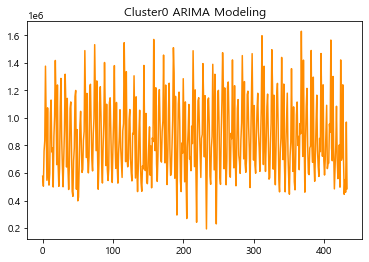

In [66]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster0 ARIMA Modeling')

#### 예측 값 저장
- cluster0에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [67]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima0') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima0']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster0 ARIMA Modeling')

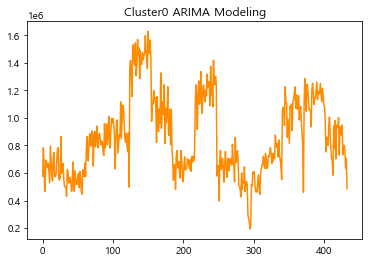

In [68]:
pd.Series(re_07[0]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster0 ARIMA Modeling')

# cluster1

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

In [ ]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_1['year_month'] = cluster_1['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_1 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_1['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_1['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster1의 경우, 2021-06, 2020-07의 각 year_month와의 코싸인 유사도가 비슷하게 나타남 
- 따라서, 2021-06에서 예측시 사용했던 year_month와 유사하게 2021-06을 추가하여 2021-07과 유사한 year_month를 선정 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [ ]:
lst_1 = ['2018-04','2018-05', '2019-03', '2019-04','2019-05','2019-06','2019-08','2019-10','2019-11','2019-12','2020-05','2020-07',
         '2020-08', '2020-09', '2020-11', '2020-12', '2021-01', '2021-04' ,'2021-06']

cluster_1 = cluster_1.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_1['dong']=encoder.fit_transform(cluster_1['emd_nm_jh'])

cluster_1 = cluster_1.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_1['base_date_jh']=pd.to_datetime(cluster_1['base_date_jh'])
cluster_1['month'] = cluster_1['base_date_jh'].dt.month
cluster_1['year'] = cluster_1['base_date_jh'].dt.year
cluster_1['week'] = cluster_1['base_date_jh'].dt.weekofyear
cluster_1['day'] = cluster_1['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_1에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_1.query('year_month in @lst_1 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_1.query('year_month not in @lst_1 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021

#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [ ]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [ ]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [ ]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [ ]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

In [ ]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster1 ARIMA Modeling')

#### 예측 값 저장
- cluster1에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [ ]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima1') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima1']) 

- 정렬된 결과로 다시 예측값 시각화

In [ ]:
pd.Series(re_07[1]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster1 ARIMA Modeling')

# cluster2

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

In [ ]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_2['year_month'] = cluster_2['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_2 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_2['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_2['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster2의 경우, 거의 모든 year_month의 코싸인 유사도가 높지만 2019-02, 2019-03에 대한 코싸인 유사도에서 차이가 있음
- 따라서, 2021-06에서 예측시 사용했던 year_month를 바탕으로 2021-06을 추가하여 2021-07과 유사한 year_month를 선정 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [ ]:
lst_2 = ['2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
 '2019-01', '2019-05', '2019-06', '2019-07', '2019-08', '2020-04', '2020-05', '2020-07', '2020-08', '2020-09', '2020-10',
 '2020-11', '2020-12', '2021-01', '2021-03', '2021-04', '2021-05', '2021-06']

cluster_2 = cluster_2.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_2['dong']=encoder.fit_transform(cluster_2['emd_nm_jh'])

cluster_2 = cluster_2.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_2['base_date_jh']=pd.to_datetime(cluster_2['base_date_jh'])
cluster_2['dayofweek'] = cluster_2['base_date_jh'].dt.dayofweek
cluster_2['month'] = cluster_2['base_date_jh'].dt.month
cluster_2['year'] = cluster_2['base_date_jh'].dt.year
cluster_2['day'] = cluster_2['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_2에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_2.query('year_month in @lst_2 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_2.query('year_month not in @lst_2 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year, dayofweek를 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021
dayofweek = cluster_2.query(' year_month == "2021-04"')['dayofweek'].reset_index(drop = True )
dfw = pd.concat( [dayofweek , pd.Series(data = [5,5,5,5,5] , index = [150,151,152,153,154]) ] ,axis = 0 ).reset_index()
dfw['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
dfw = dfw.set_index('index') ;dfw.columns = ['dayofweek']
X_test['dayofweek'] = dfw

#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [ ]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

In [ ]:
n = cluster_2.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행
- cluster2의 2021-06 예측 시, 차분을 진행했기 때문에 2021-07 예측에도 d=1로 설정 

In [83]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=59405.965, Time=27.63 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=59378.946, Time=9.30 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=59410.147, Time=13.59 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=59400.012, Time=11.77 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=59424.497, Time=13.09 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=59408.533, Time=7.58 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=59410.222, Time=9.29 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=59416.771, Time=11.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[1] intercept
Total fit time: 191.486 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [84]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,1,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [85]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster2 ARIMA Modeling')

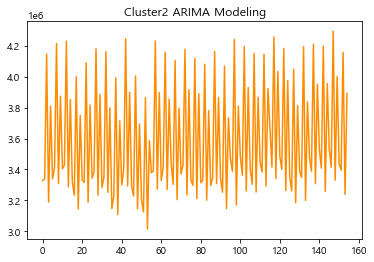

In [86]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster2 ARIMA Modeling')

#### 예측 값 저장
- cluster2에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [87]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima2') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima2']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster2 ARIMA Modeling')

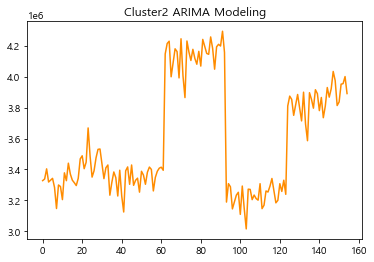

In [88]:
pd.Series(re_07[2]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster2 ARIMA Modeling')

# cluster3

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

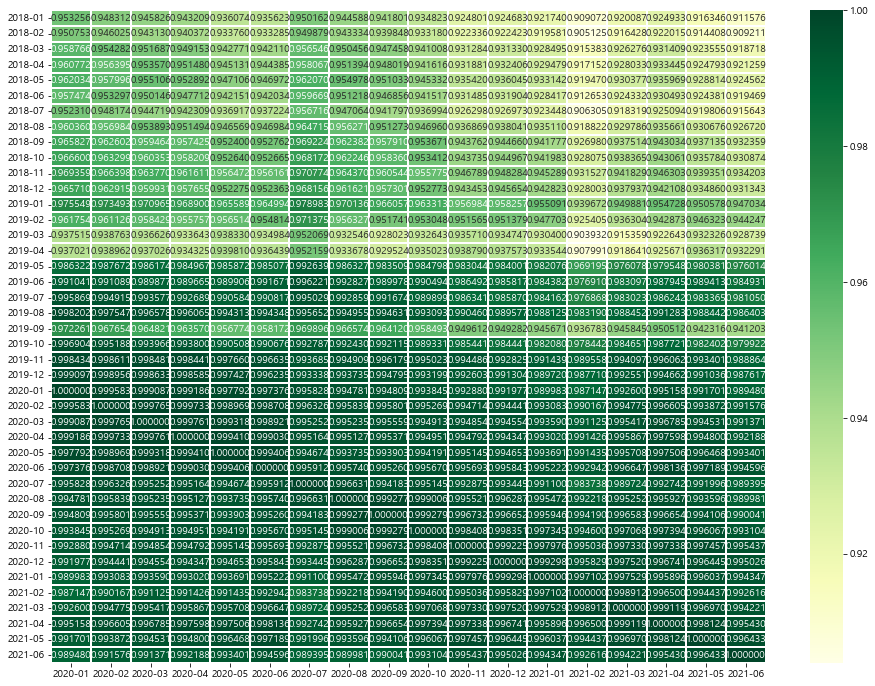

In [89]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_3['year_month'] = cluster_3['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_3 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_3['year_month'].unique()[24:] : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_3['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- 2020-07, 2021-06은 각 year_month와의 코싸인 유사도 패턴이 유사하지 않음
- 따라서, 2021-06에서 예측시 사용했던 year_month을 바탕으로 2020-07과 유사한 year_month를 추가하여2021-07과 유사한 year_month를 선정 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [90]:
lst_3 = ['2020-01','2020-02', '2020-07', '2020-08','2020-10', '2021-01','2021-03', '2021-04', '2021-05' ,'2021-06']

cluster_3 = cluster_3.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_3['dong']=encoder.fit_transform(cluster_3['emd_nm_jh'])

cluster_3 = cluster_3.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_3['base_date_jh']=pd.to_datetime(cluster_3['base_date_jh'])
cluster_3['month'] = cluster_3['base_date_jh'].dt.month
cluster_3['year'] = cluster_3['base_date_jh'].dt.year
cluster_3['week'] = cluster_3['base_date_jh'].dt.weekofyear
cluster_3['day'] = cluster_3['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_3에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_3.query('year_month in @lst_3 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_3.query('year_month not in @lst_3 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [91]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -7.348
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [92]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=294057.097, Time=5.72 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=294014.382, Time=17.59 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=294004.209, Time=19.02 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=294006.203, Time=18.77 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=294011.548, Time=5.98 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=293687.973, Time=131.34 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=293684.815, Time=139.62 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=293686.402, Time=211.58 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=294003.182, Time=8.89 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=294004.945, Time=23.39 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=188.56 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=225.98 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=294005.120, Time=15.05 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=294007.168, Time=18.73 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf,

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [93]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(1,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [94]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster3 ARIMA Modeling')

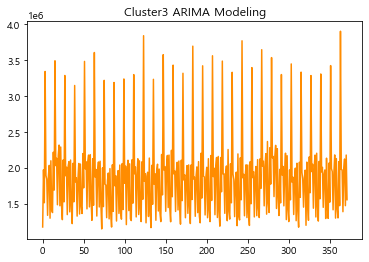

In [95]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster3 ARIMA Modeling')

#### 예측 값 저장
- cluster3에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [96]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima3') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima3']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster3 ARIMA Modeling')

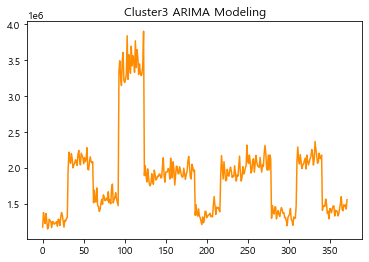

In [97]:
pd.Series(re_07[3]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster3 ARIMA Modeling')

# cluster4

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

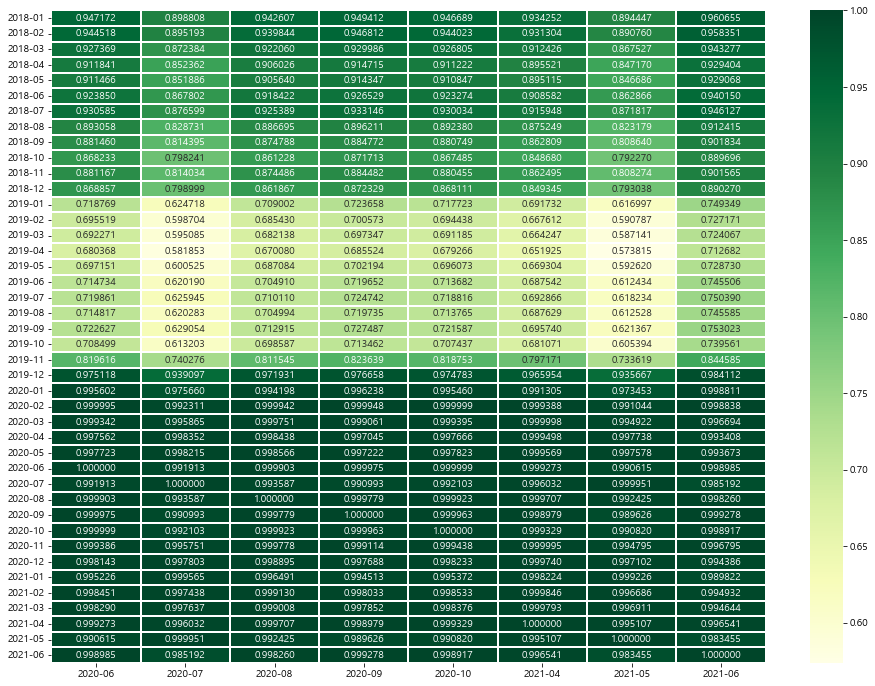

In [98]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_4['year_month'] = cluster_4['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_4 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in ['2020-06','2020-07','2020-08','2020-09','2020-10','2021-04','2021-05','2021-06'] : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_4['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster4의 경우, 최근 1년 정도의 year_month의 코싸인 유사도가 높은것으로 나타남
- 따라서, 2021-06에서 예측시 사용했던 year_month에 2021-06, 2020-07을 추가하여 2021-07과 유사한 year_month로 선정 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [99]:
lst_4 = [ '2020-06', '2020-07' , '2020-09' , '2021-06']

cluster_4 = cluster_4.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_4['dong']=encoder.fit_transform(cluster_4['emd_nm_jh'])

cluster_4 = cluster_4.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_4['base_date_jh']=pd.to_datetime(cluster_4['base_date_jh'])
cluster_4['dayofweek'] = cluster_4['base_date_jh'].dt.dayofweek
cluster_4['month'] = cluster_4['base_date_jh'].dt.month
cluster_4['year'] = cluster_4['base_date_jh'].dt.year
cluster_4['day'] = cluster_4['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_4에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_4.query('year_month in @lst_4 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_4.query('year_month not in @lst_4')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year, dayofweek를 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021
dayofweek = cluster_4.query(' year_month == "2021-04"')['dayofweek'].reset_index(drop = True )
dfw = pd.concat( [dayofweek , pd.Series(data = [5,5] , index = [62, 63]) ] ,axis = 0 ).reset_index()
dfw['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
dfw = dfw.set_index('index') ;dfw.columns = ['dayofweek']
X_test['dayofweek'] = dfw

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [100]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -0.597
원 데이터 p-value: 0.872


#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

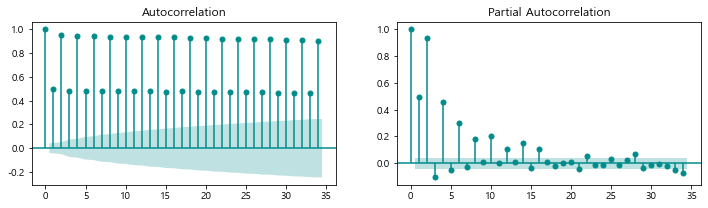

In [101]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

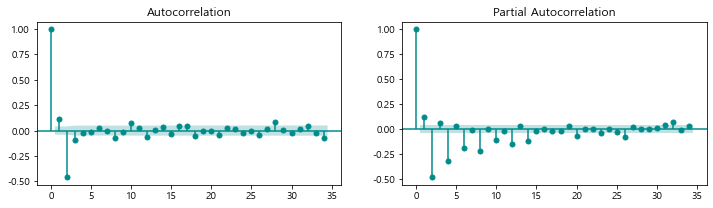

In [102]:
n = cluster_4.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행
- cluster4의 2021-06 예측 시, 차분을 진행했기 때문에 2021-07 예측에도 d=1로 설정 

In [103]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=57301.030, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=55796.021, Time=7.17 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=10.34 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=55770.310, Time=10.87 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=56656.415, Time=6.46 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=8.80 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=55782.585, Time=17.89 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=18.11 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=56385.456, Time=7.67 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=11.41 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=17.00 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=28.94 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=56242.110, Time=8.51 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=56026.791, Time=16.38 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=14.23 sec

Best model:  ARIMA(0,1,3)(0

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [104]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,1,3),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [105]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster4 ARIMA Modeling')

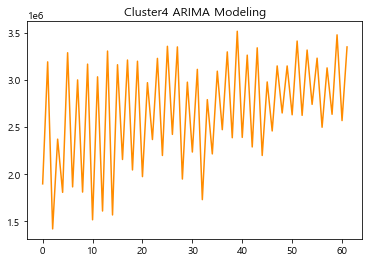

In [106]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster4 ARIMA Modeling')

#### 예측 값 저장
- cluster4에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [107]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima4') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima4']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster4 ARIMA Modeling')

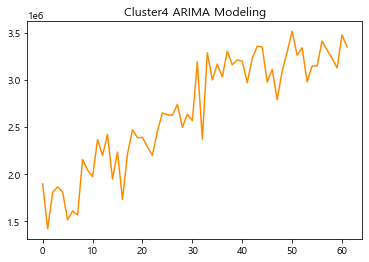

In [108]:
pd.Series(re_07[4]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster4 ARIMA Modeling')

# cluster5

#### 2021-07 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-07과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

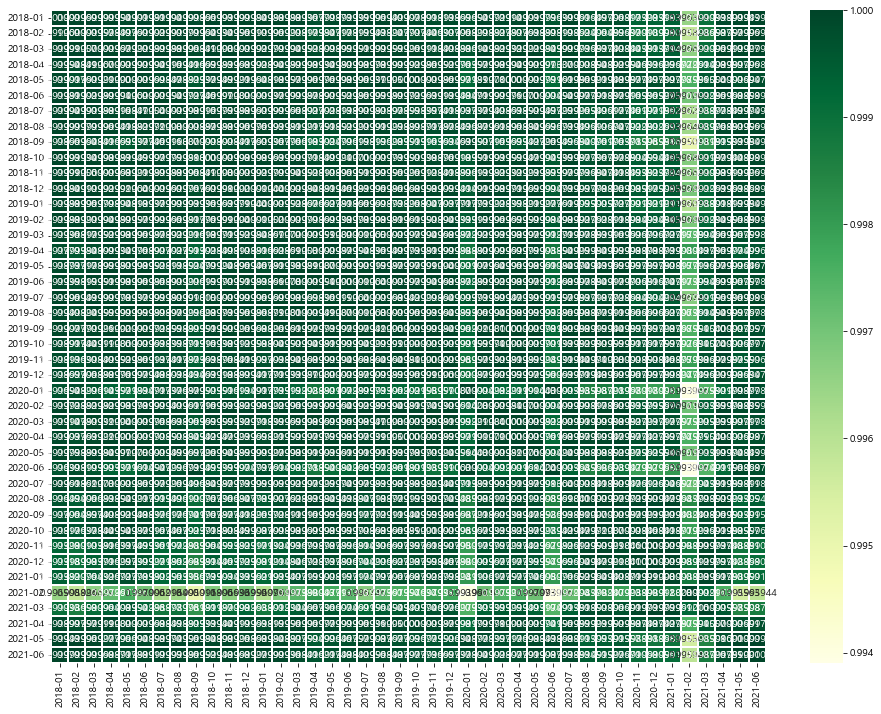

In [109]:
# 년도-월 형태로 생긴 year_month 변수 생성 
cluster_5['year_month'] = cluster_5['base_date_jh'].apply(lambda x : x[:7])

# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_5 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_5['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_5['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- 2021-06, 2020-07은 2021-02와의 코싸인 유사도에서 약간의 차이가 있음
- 다만, 2021-02와의 코싸인 유사도 증감 추세는 유사함
- 따라서 2021-04, 2021-05, 2021-06 와 2020-07의 평균이 2021-07과 유사할 것이라고 가정함

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [110]:
lst_5 = ['2020-07' , '2021-05' ,'2021-06']

cluster_5 = cluster_5.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 동 구별을 위한 라벨인코딩
encoder = LabelEncoder()
cluster_5['dong']=encoder.fit_transform(cluster_5['emd_nm_jh'])

cluster_5 = cluster_5.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 시계열 데이터에 맞에 시간적 특성을 가진 열 추가
cluster_5['base_date_jh']=pd.to_datetime(cluster_5['base_date_jh'])
cluster_5['month'] = cluster_5['base_date_jh'].dt.month
cluster_5['year'] = cluster_5['base_date_jh'].dt.year
cluster_5['week'] = cluster_5['base_date_jh'].dt.weekofyear
cluster_5['day'] = cluster_5['base_date_jh'].dt.day

# 위에서 찾은 2021-07과 유사한 year_month를 담은 lst_5에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_5.query('year_month in @lst_5 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_5.query('year_month not in @lst_5 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 7
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [111]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}') 

원 데이터 ADF Statistic: -3.453
원 데이터 p-value: 0.009


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [112]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=65034.907, Time=1.38 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=64906.151, Time=3.92 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=64812.749, Time=3.27 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=64814.855, Time=4.28 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=64854.646, Time=6.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=64747.648, Time=9.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=64722.334, Time=13.73 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=64702.578, Time=12.47 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=64796.629, Time=3.19 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=64672.248, Time=13.47 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=64657.975, Time=22.14 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=64554.552, Time=13.16 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=64797.936, Time=3.60 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=64669.506, Time=15.33 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=64562.366, Tim

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [113]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(2,0,3),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [114]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster5 ARIMA Modeling')

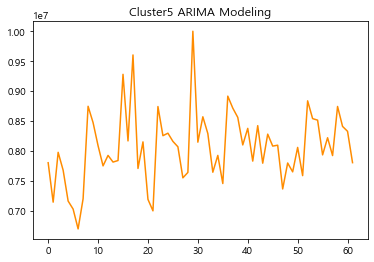

In [115]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster5 ARIMA Modeling')

#### 예측 값 저장
- cluster5에 대한 7월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [116]:
re_07.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima5') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima5']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster5 ARIMA Modeling')

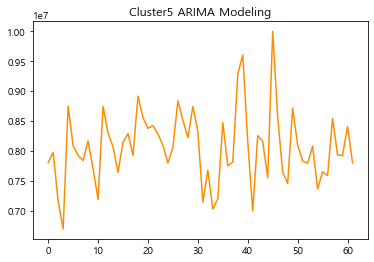

In [117]:
pd.Series(re_07[5]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster5 ARIMA Modeling')

In [118]:
df2 = re_07[0].reset_index(drop=True)

for i in range(1,6) :
    a = re_07[i].reset_index(drop= True)
    df2 = pd.concat( [df2, a] , axis = 1 )

In [119]:
df2.to_csv('predict/arima_07_predict.csv' , index = False)

# 2021-08 예측

In [120]:
re_08 = [] # 예측값 저장을 위한 리스트

# cluster0

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

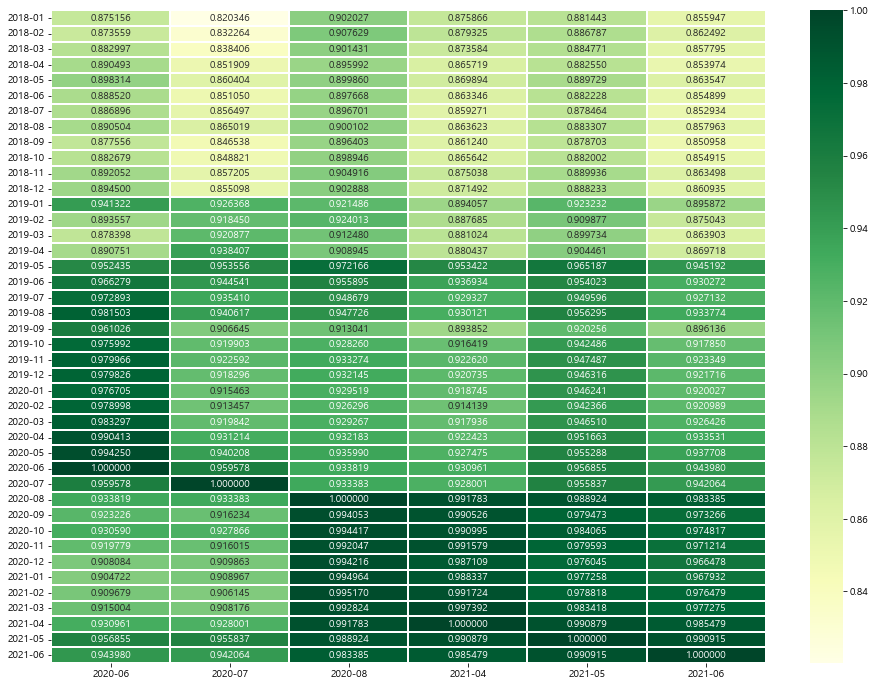

In [121]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_0 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in ['2020-06','2020-07','2020-08','2021-04','2021-05','2021-06'] : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_0['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- 2021-06, 2020-08는 각 2019-05이후 year_month와의 코싸인 유사도 증감이 유사한것으로 보인다. 
- 따라서 2021-08과 유사한 year_month를 2020-08, 2021-06로 선정

#### train, test data set 구축
- 앞에서 선정한 2021-08 유사 year_month에 대한 데이터를 평균내어 test data set으로, 나머지 데이터를 train data set으로 사용

In [122]:
lst_0 = ['2020-08' , '2021-06']

cluster_0 = cluster_0.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_0에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_0.query('year_month in @lst_0 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_0.query('year_month not in @lst_0 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [123]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -8.694
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [124]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=436456.669, Time=4.74 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=436455.805, Time=15.51 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=436432.072, Time=20.77 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=436258.457, Time=24.96 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=436456.004, Time=4.84 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=436457.394, Time=42.31 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=436341.538, Time=42.32 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=436227.760, Time=52.60 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=436435.364, Time=7.18 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=436309.682, Time=55.24 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=433459.055, Time=198.82 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=433291.925, Time=214.38 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=436191.780, Time=13.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=436098.116, Time=39.86 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept  

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [125]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=( 3,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [126]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster0 ARIMA Modeling')

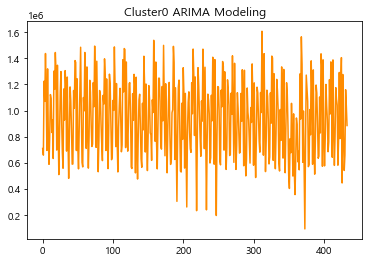

In [127]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster0 ARIMA Modeling')

#### 예측 값 저장
- cluster0에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [128]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima0') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima0']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster0 ARIMA Modeling')

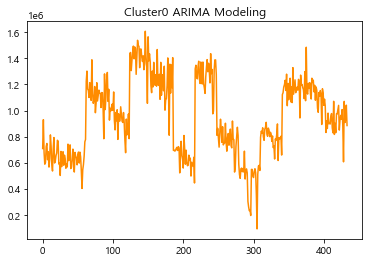

In [129]:
pd.Series(re_08[0]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster0 ARIMA Modeling')

# cluster1

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

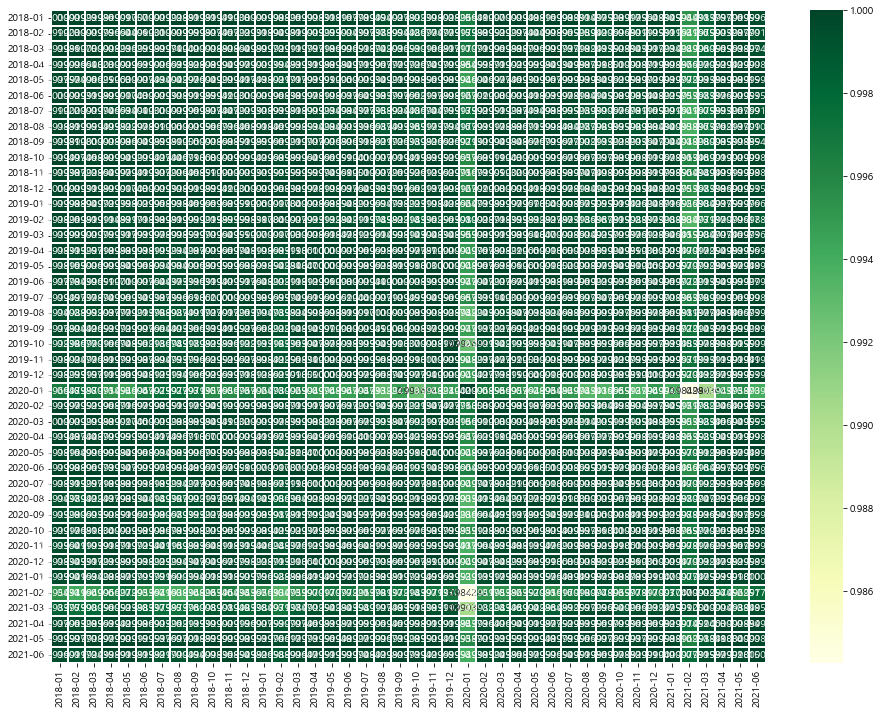

In [130]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_1 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_1['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_1['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster1의 경우, 2021-06, 2020-08의 각 year_month와의 코싸인 유사도가 비슷하게 나타남 
- 따라서, 2021-06에서 예측시 사용했던 year_month와 유사하게 2021-06을 추가하여 2021-08과 유사한 year_month를 선정 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [131]:
lst_1 = ['2018-05', '2018-08','2019-04','2019-05','2019-06','2019-10','2019-11','2019-12','2020-05','2020-07',
         '2020-08', '2020-09', '2020-10' , '2020-11', '2021-01', '2021-04' ,'2021-06']

cluster_1 = cluster_1.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_0에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_1.query('year_month in @lst_1 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_1.query('year_month not in @lst_1 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [132]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -5.059
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [133]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=39026.179, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=39028.159, Time=1.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=38705.939, Time=1.34 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=38707.938, Time=1.48 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=39028.136, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=38982.141, Time=3.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=38707.932, Time=1.84 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=38709.938, Time=1.69 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=38769.990, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=38771.989, Time=1.85 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=38709.922, Time=2.12 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=38711.929, Time=2.67 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=38771.985, Time=1.06 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=38767.295, Time=6.15 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=38711.889, Time=3.86

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [134]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,0,2),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [135]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster1 ARIMA Modeling')

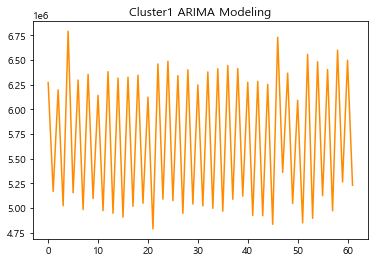

In [136]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster1 ARIMA Modeling')

#### 예측 값 저장
- cluster1에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [137]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima1') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima1']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster1 ARIMA Modeling')

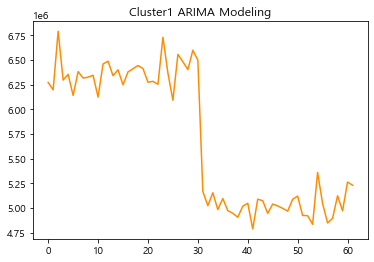

In [138]:
pd.Series(re_08[1]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster1 ARIMA Modeling')

# cluster2

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

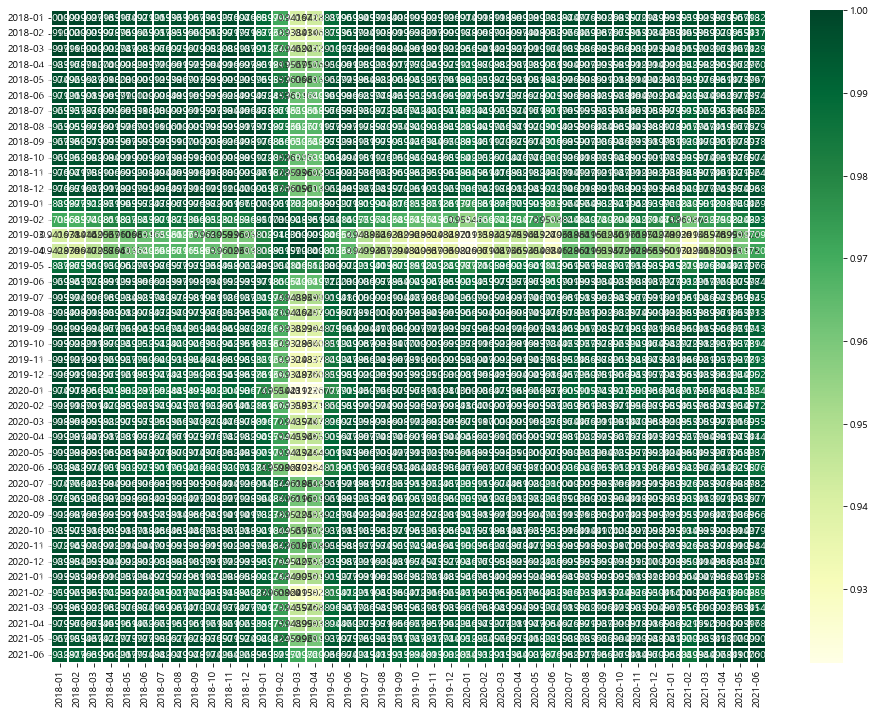

In [139]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_2 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_2['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_2['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster2의 경우, 2021-06과 2020-08는 각 year_month의 코싸인 유사도 패턴이 유사함
- 따라서, 모든 year_month 중 2021-06 , 2020-08과 유사한 year_month를 2021-08 유사 year_month로 선정
- 2021-06 예측 시에 사용했던 year_month 중 2018-01, 2018-03, 2018-04, 2019-07 , 2019-08을 제외하고 2021-06을 추가 

#### train, test data set 구축
- 앞에서 선정한 2021-07 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [140]:
lst_2 = ['2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
 '2019-01', '2019-05', '2019-06', '2020-03', '2020-04', '2020-05', '2020-07', '2020-08', '2020-09', '2020-10',
 '2020-11', '2020-12', '2021-01', '2021-03', '2021-04', '2021-05', '2021-06']

cluster_2 = cluster_2.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_2에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_2.query('year_month in @lst_2 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_2.query('year_month not in @lst_2 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year, dayofweek를 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021
dayofweek = cluster_2.query(' year_month == "2020-11"')['dayofweek'].reset_index(drop = True )
dfw = pd.concat( [dayofweek , pd.Series(data = [1,1,1,1,1] , index = [150,151,152,153,154]) ] ,axis = 0 ).reset_index()
dfw['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
dfw = dfw.set_index('index') ;dfw.columns = ['dayofweek']
X_test['dayofweek'] = dfw

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [141]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -4.944
원 데이터 p-value: 0.000


#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

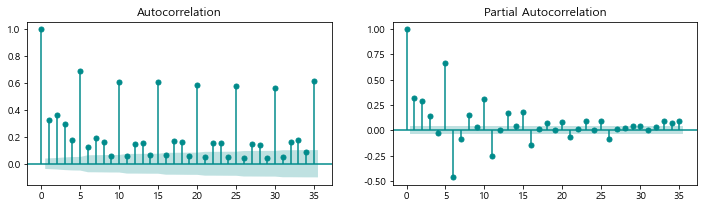

In [142]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

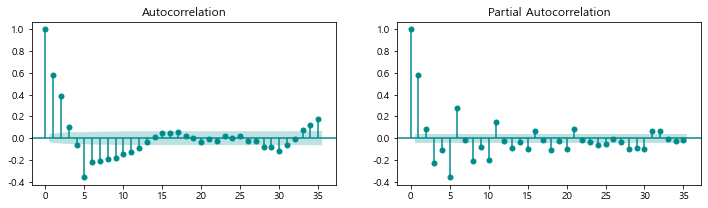

In [143]:
n = cluster_2.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행
- cluster2의 2021-06 예측 시, 차분을 진행했기 때문에 2021-08 예측에도 d=1로 설정 

In [144]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=67917.067, Time=6.59 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=68007.558, Time=8.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=67979.997, Time=12.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=67985.113, Time=15.74 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=67961.892, Time=7.73 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=68011.154, Time=9.72 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=68020.603, Time=8.80 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=68030.284, Time=21.38 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=67989.953, Time=18.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=68014.917, Time=9.35 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=68023.544, Time=16.92 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=68062.862, Time=31.01 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=68011.690, Time=16.24 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=68013.654, Time=25.42 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=68029.954, T

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [145]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=( 0,1,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [146]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster2 ARIMA Modeling')

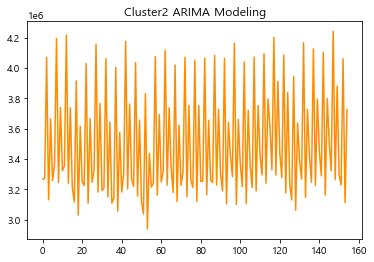

In [147]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster2 ARIMA Modeling')

#### 예측 값 저장
- cluster2에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [148]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima2') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima2']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster2 ARIMA Modeling')

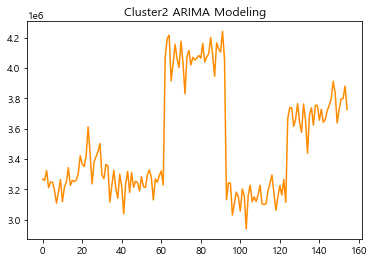

In [149]:
pd.Series(re_08[2]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster2 ARIMA Modeling')

# cluster3

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

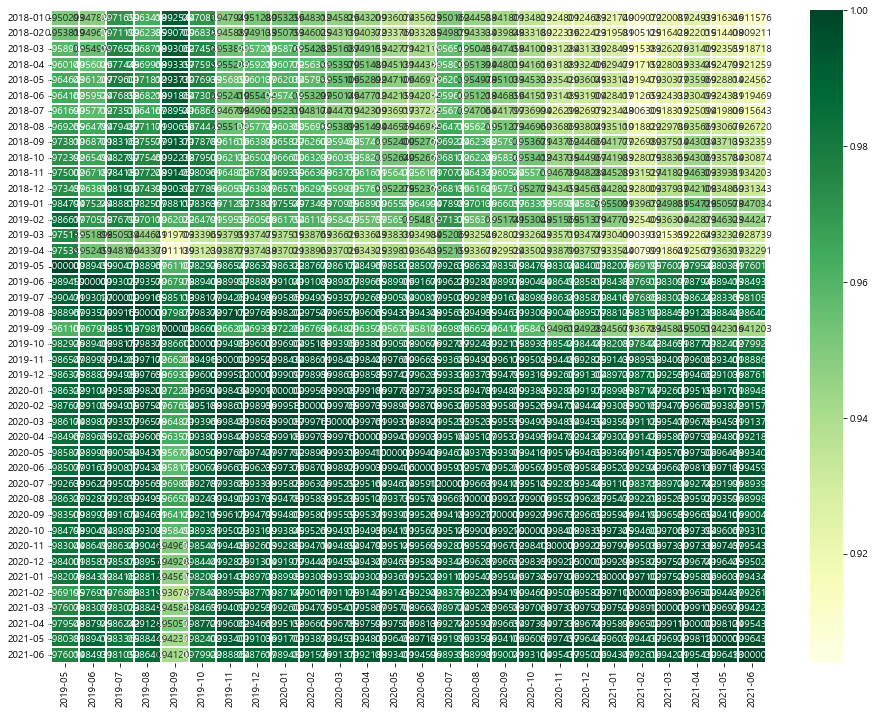

In [150]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_3 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_3['year_month'].unique()[16:]: 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_3['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster3의 경우, 2019-09를 제외한 2019-05 이전의 모든 year_month의 코싸인 유사도가 높게 나타남
- 2020-08, 2021-06과 유사한 year_month를 골라 2021-08과 유사한 year_month로 선정

#### train, test data set 구축
- 앞에서 선정한 2021-08 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [151]:
lst_3 = ['2019-11' , '2020-03', '2020-04', '2020-08', '2020-09', '2020-10',
         '2021-01', '2021-03', '2021-04', '2021-05' ,'2021-06']

cluster_3 = cluster_3.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_3에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_3.query('year_month in @lst_3 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_3.query('year_month not in @lst_3 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [152]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -7.065
원 데이터 p-value: 0.000


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [153]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=285413.676, Time=5.61 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=285373.050, Time=16.93 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=285360.891, Time=17.96 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=285362.883, Time=21.53 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=285370.086, Time=5.64 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=285078.478, Time=118.77 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=285362.773, Time=21.65 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=285364.857, Time=22.24 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=285359.877, Time=8.27 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=285361.841, Time=13.99 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=225.26 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=223.66 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=285361.865, Time=8.33 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=285363.877, Time=17.62 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf, Ti

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [154]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(1,0,1),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [155]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster3 ARIMA Modeling')

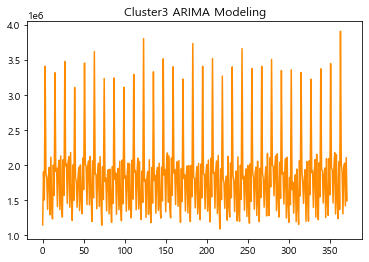

In [156]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster3 ARIMA Modeling')

#### 예측 값 저장
- cluster3에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [157]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima3') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima3']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster3 ARIMA Modeling')

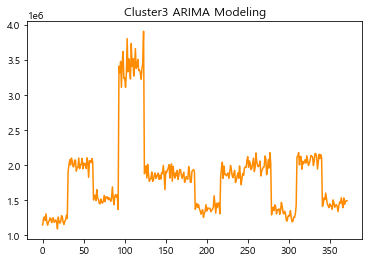

In [158]:
pd.Series(re_08[3]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster3 ARIMA Modeling')

# cluster4

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

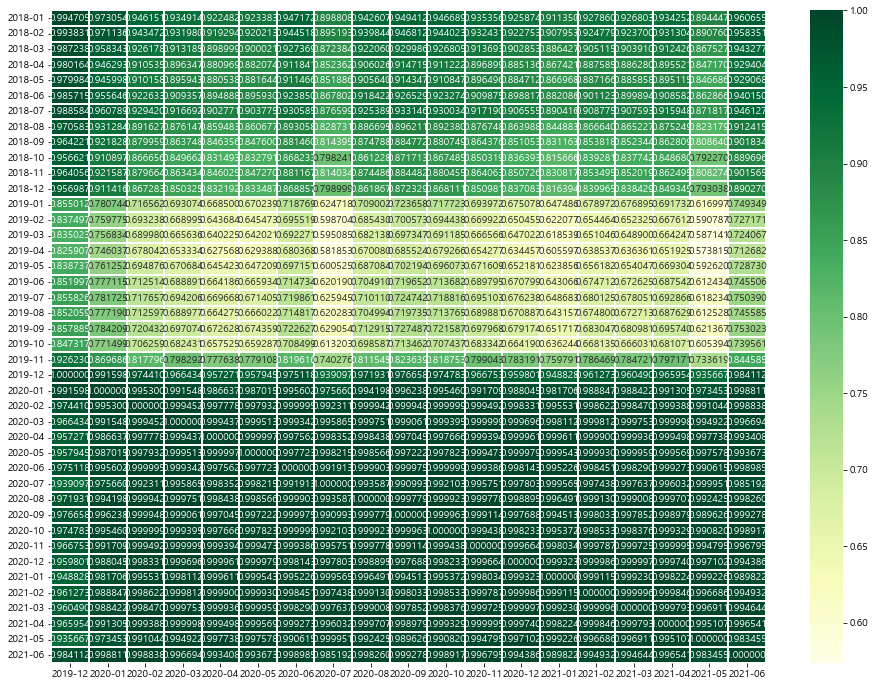

In [159]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_4 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_4['year_month'].unique()[23:] : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_4['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- cluster4의 경우, 최근 1년 정도의 year_month의 코싸인 유사도가 높은것으로 나타남
- 2021-06, 2020-08와 모두 유사한 year_month를 2021-08 유사 year_month로 선정

#### train, test data set 구축
- 앞에서 선정한 2021-08 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [160]:
lst_4 = [ '2020-01', '2020-08' , '2020-09' , '2021-06']

cluster_4 = cluster_4.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_4에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_4.query('year_month in @lst_4 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_4.query('year_month not in @lst_4')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year, dayofweek를 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021
dayofweek = cluster_4.query(' year_month == "2020-11"')['dayofweek'].reset_index(drop = True )
dfw = pd.concat( [dayofweek , pd.Series(data = [1,1] , index = [62, 63]) ] ,axis = 0 ).reset_index()
dfw['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
dfw = dfw.set_index('index') ;dfw.columns = ['dayofweek']
X_test['dayofweek'] = dfw

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [161]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -0.405
원 데이터 p-value: 0.909


#### acf , pacf plot 그리기
- 평균을 정상화하기 위해 현재 시점에서 이전 시점의 자료를 빼는 차분을 진행하고 차분이 잘 되었는지 acf, pacf plot을 통해 확인

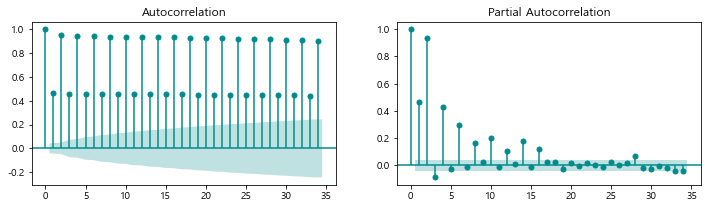

In [162]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(y_train,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(y_train, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

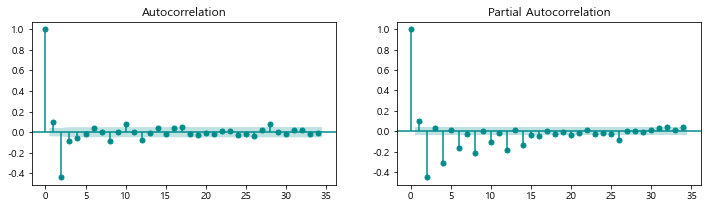

In [163]:
n = cluster_4.emd_nm_jh.nunique()
diffed= y_train.diff(n).dropna()

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행
- cluster4의 2021-06 예측 시, 차분을 진행했기 때문에 2021-08 예측에도 d=1로 설정 

In [164]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=59374.906, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=59657.080, Time=2.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=59771.875, Time=5.64 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=59802.381, Time=13.44 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=59456.966, Time=3.66 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=59673.606, Time=4.32 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=59797.240, Time=8.79 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=59821.382, Time=10.43 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=59574.078, Time=1.97 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=59672.288, Time=11.55 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=59826.276, Time=3.75 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=59841.791, Time=18.46 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=59667.274, Time=5.05 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=59668.974, Time=7.69 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=59815.888, Time=

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [165]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(0,1,0),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [166]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster4 ARIMA Modeling')

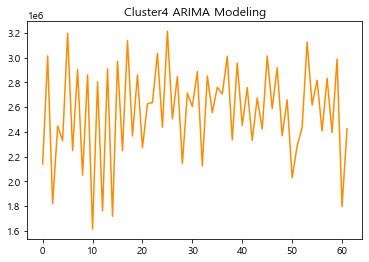

In [167]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster4 ARIMA Modeling')

#### 예측 값 저장
- cluster4에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [168]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima4') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima4']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster4 ARIMA Modeling')

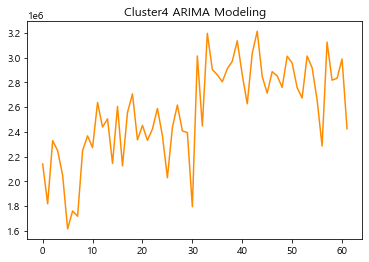

In [169]:
pd.Series(re_08[4]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster4 ARIMA Modeling')

# cluster5

#### 2021-08 유사 year_month 선정 
- 2021-06의 예측 과정에서 사용된 year-month를 바탕으로 2021-08과 유사한 year-month를 찾기 위해 각 year_month별 코싸인 유사도를 구하고 시각화를 진행함 

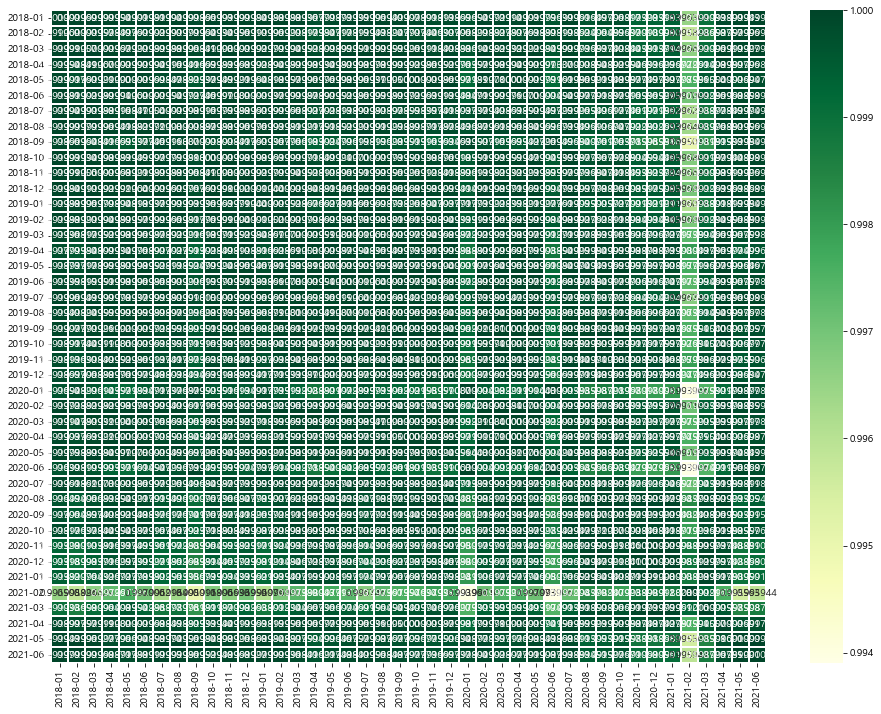

In [170]:
# year_month와 emd_nm_jh (동) 을 기준으로 음식물 쓰레기 배출량의 합에 대한 pivot table 생성
coss = pd.pivot_table(cluster_5 , columns = ['year_month'], values = ['em_g_jh'], index = ['emd_nm_jh'], aggfunc = [sum], fill_value = 0)

# 2021-06 예측에 사용되었던 year_month를 포함하여 각 year_month에 대해 코싸인 유사도 계산 후 시각화 
coo = []
for i in cluster_5['year_month'].unique() : 
    co = []
    for j in range(42) : 
        c = cos_sim(coss.iloc[:,j] , coss.loc[:, ('sum', 'em_g_jh', i )] )
        co.append(c)
    name = coss.loc[:, ('sum', 'em_g_jh', i )].name[2]
    seri = pd.Series(data = co , index = cluster_5['year_month'].unique()).rename( name )
    coo.append(seri)
    
sim = coo[0]    
for i in coo[1:] : 
    sim = pd.concat([sim, i] , axis = 1)
    
plt.figure(figsize = (16,12))
sns.heatmap(sim , annot=True, fmt='f', linewidths= 1, cmap='YlGn')
plt.show()

- 2021-06, 2020-08은 2021-02와의 코싸인 유사도에서 약간의 차이가 있음
- 다만, 2021-02와의 코싸인 유사도 증감 추세는 유사함
- 따라서 2021-04, 2021-05, 2021-06 와 2020-08의 평균이 2021-08의 유사할 것이라고 가정함

#### train, test data set 구축
- 앞에서 선정한 2021-08 유사 year_month에 대한 데이터를 test data set, 나머지 데이터를 train data set으로 사용

In [171]:
lst_5 = ['2020-08' ,'2021-04' ,'2021-05' ,'2021-06']

cluster_5 = cluster_5.sort_values(by = ['base_date_jh', 'emd_nm_jh'] )

# 위에서 찾은 2021-08과 유사한 year_month를 담은 lst_0에 대한 데이터를 활용해 day와 emd_nm_jh 별로 평균을 내어 test set으로 사용
X_test = cluster_5.query('year_month in @lst_5 ') 
X_test = X_test.groupby(['day' , 'emd_nm_jh' ]).mean().reset_index()

# test set에 사용하지 않은 데이터를 train set으로 사용
X_train = cluster_5.query('year_month not in @lst_5 ')

# ARIMA를 위해 인덱스를 연속적인 값으로 변경
ind = X_train.shape[0]
X_train['index'] = [ i for i in range(0,ind)] 
X_train = X_train.set_index('index')
X_test['index'] = [ i for i in range(ind,ind+X_test.shape[0])]
X_test = X_test.set_index('index')

# y값 분리
y_train = X_train['em_g_jh'] 

# X_test의 column 순서를 X_train과 동일하게 변경
col1=X_test.columns[1:].to_list()
new_col=col1+['day']
X_test=X_test[new_col]

# 예측 후 결과 정렬을 위해 X_test의 emd_nm_jh과 day를 sor에 저장
sor = X_test[['emd_nm_jh','day']].reset_index(drop = True )

# 필요없는 column drop
X_train = X_train.drop(['base_date_jh' , 'em_g_jh' ,'emd_nm_jh' ,'year_month'], axis = 1) 
X_test = X_test.drop([ 'em_g_jh' , 'emd_nm_jh' ], axis = 1)

# month 와 year은 타겟에 맞게 다시 지정
X_test['month'] = 8
X_test['year'] = 2021

C:\anaconda3\envs\tens2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### ADF 검정
- 데이터의 정상성 만족 여부 파악을 위한 ADF 검정

In [172]:
result = adfuller(y_train)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')  

원 데이터 ADF Statistic: -3.524
원 데이터 p-value: 0.007


#### auto_arima
- 최소의 AIC 값을 갖는 차수(p,q,d)를 찾기 위해 auto_arima 진행

In [173]:
model_arima= auto_arima(y_train ,X= X_train ,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=0,suppress_warnings=True,stepwise=False,seasonal=True )
model_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=63383.930, Time=1.44 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=63264.660, Time=3.61 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=63183.107, Time=3.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=63184.947, Time=5.07 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=63220.573, Time=5.64 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=63123.779, Time=14.95 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=63101.801, Time=12.67 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=63086.439, Time=12.62 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=63173.837, Time=3.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=63044.527, Time=18.98 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=63037.036, Time=15.86 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=62934.990, Time=10.61 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=63174.520, Time=3.52 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=63044.920, Time=22.07 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=62946.683, Ti

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### ARIMA
- auto_arima를 사용하여 찾은 최적의 차수를 활용하여 학습 및 예측 진행

In [174]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(y_train,order=(2,0,3),exog = X_train,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()

In [175]:
forecast = sarimax.predict(ind,ind+X_test.shape[0]-1 ,dynamic=False, exog=X_test )

#### 예측 결과 확인

Text(0.5, 1.0, 'Cluster5 ARIMA Modeling')

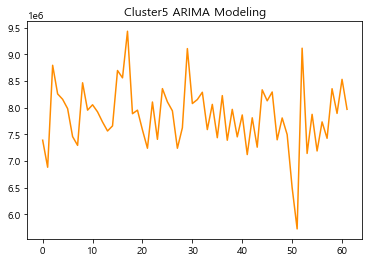

In [176]:
pd.Series(forecast).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster5 ARIMA Modeling')

#### 예측 값 저장
- cluster5에 대한 8월 배출량 예측 결과를 동별로 재정렬 후 리스트에 저장

In [177]:
re_08.append( pd.concat([sor ,forecast.reset_index(drop = True ).rename('arima5') ] ,axis = 1 ).sort_values(by = ['emd_nm_jh', 'day']).reset_index(drop = True )['arima5']) 

- 정렬된 결과로 다시 예측값 시각화

Text(0.5, 1.0, 'Cluster5 ARIMA Modeling')

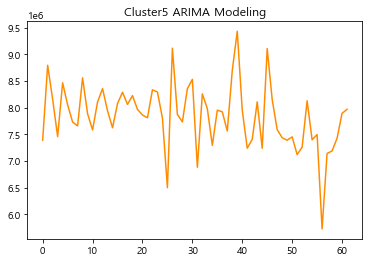

In [178]:
pd.Series(re_08[5]).reset_index(drop=True).plot(color = 'darkorange')
plt.title('Cluster5 ARIMA Modeling')

In [179]:
df3 = re_08[0].reset_index(drop=True)

for i in range(1,6) :
    a = re_08[i].reset_index(drop= True)
    df3 = pd.concat( [df3, a] , axis = 1 )

In [180]:
df3.to_csv('predict/arima_08_predict.csv' , index = False)